In [3]:
%load_ext rpy2.ipython

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


In [1]:
# preprocess out_msstats.csv

import pandas as pd

def remove_decoy(Pro):
    if "CONTAMINANT" in Pro or "DECOY_" in Pro:
        t = []
        for p in Pro.split(";"):
            if "CONTAMINANT" in p or "DECOY_" in p:
                pass
            else:
                t.append(p)
        return ";".join(t)
    else:
        return Pro
    
data = pd.read_csv("../datasets/PXD014414/out_msstats.csv", sep=",")
data['ProteinName'] = data.apply(lambda x: remove_decoy(x.ProteinName), axis=1)
data.to_csv("../datasets/PXD014414/out_msstats_pre.csv", index=False, sep=",")

In [4]:
%%R -w 800 -h 600

library('MSstatsTMT', warn.conflicts = F, quietly = T, verbose = F)
data_folder = '../datasets/PXD014414'
setwd(data_folder)
openms_output = './out_msstats_pre.csv'

raw.om <- read.csv(openms_output, header = TRUE, sep = ',')
raw.om$Condition[which(raw.om$Condition == "not applicable|Reference Sample")] <- "Norm"
input.om <- OpenMStoMSstatsTMTFormat(raw.om)

head(input.om)

INFO  [2021-09-14 09:59:57] ** Raw data from OpenMS imported successfully.
INFO  [2021-09-14 09:59:57] ** Raw data from OpenMS cleaned successfully.
INFO  [2021-09-14 09:59:57] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements within each run will be removed.
INFO  [2021-09-14 09:59:57] ** Features with all missing measurements across channels within each run are removed.
INFO  [2021-09-14 09:59:57] ** Shared peptides are removed.
INFO  [2021-09-14 09:59:57] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-09-14 10:00:01] ** PSMs have been aggregated to peptide ions.
INFO  [2021-09-14 10:00:02] ** For peptides overlapped between fractions of 2_2_2 use the fraction with maximal average abundance.
INFO  [2021-09-14 10:00:02] ** For peptides overl

INFO  [2021-09-14 10:00:06] ** MSstatsTMT - proteinSummarization function
INFO  [2021-09-14 10:00:06] Summarizing for Run : 2_2_2 ( 1  of  3 )
  |======================================================================| 100%
INFO  [2021-09-14 10:00:22] Summarizing for Run : 3_3_3 ( 2  of  3 )
  |======================================================================| 100%
INFO  [2021-09-14 10:00:40] Summarizing for Run : 1_1_1 ( 3  of  3 )
  |======================================================================| 100%
INFO  [2021-09-14 10:00:55] ** Protein-level summarization done by MSstats.
[1] "metaplastic breast carcinomas|Chondroid"      
[2] "metaplastic breast carcinomas|Spindle"        
[3] "metaplastic breast carcinomas|Squamous"       
[4] "Normal|Normal breast"                         
[5] "Triple-negative breast cancer|Triple-negative"


R[write to console]: Drew the Profile plot for 1 proteins.



  |======================================================================| 100%


R[write to console]: Drew the Profile plot with summarization for 1 proteins.



  |======================================================================| 100%


R[write to console]: Drew the Quality Contol plot(boxplot) over all proteins.



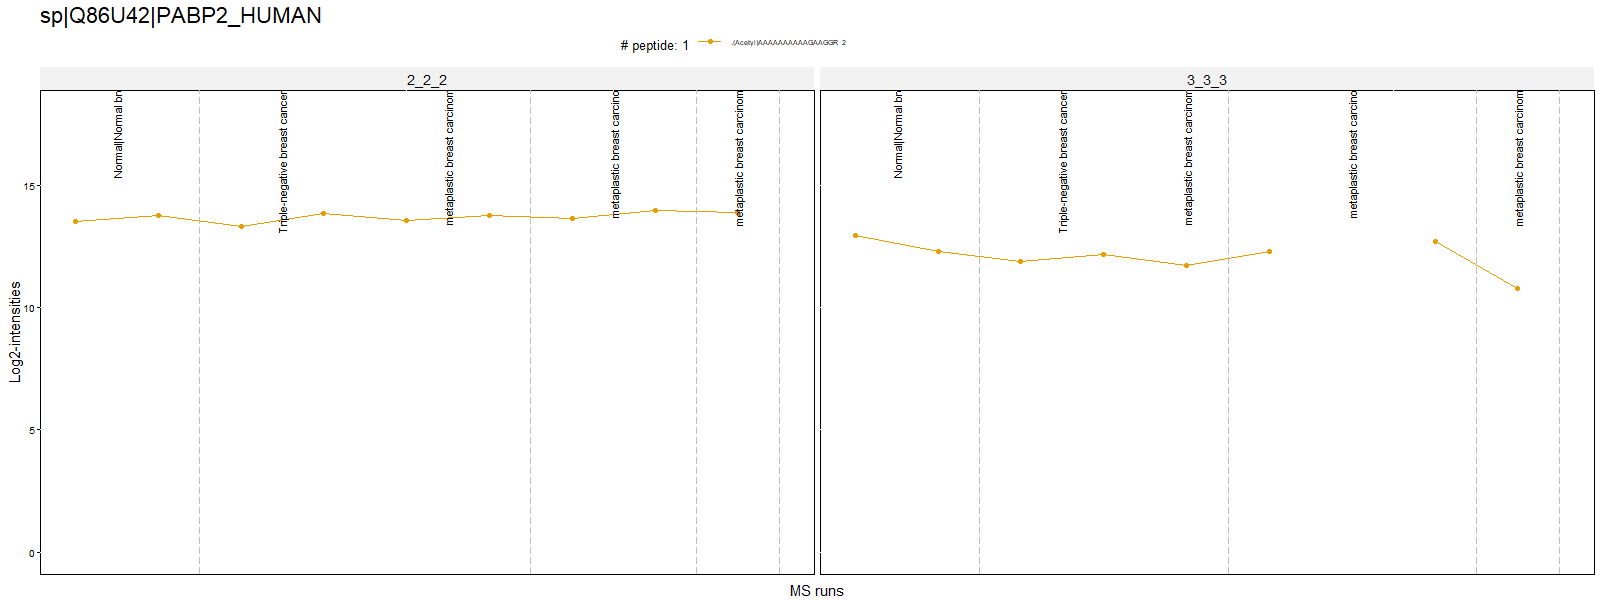

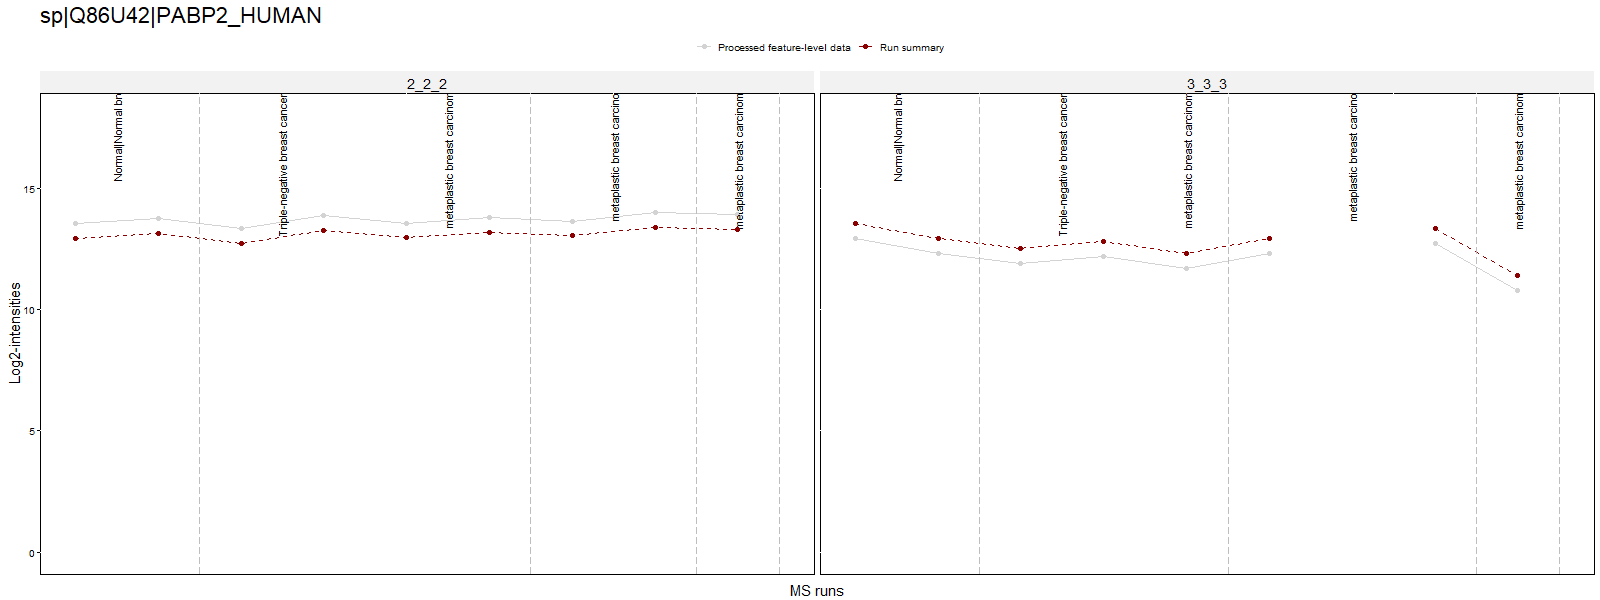

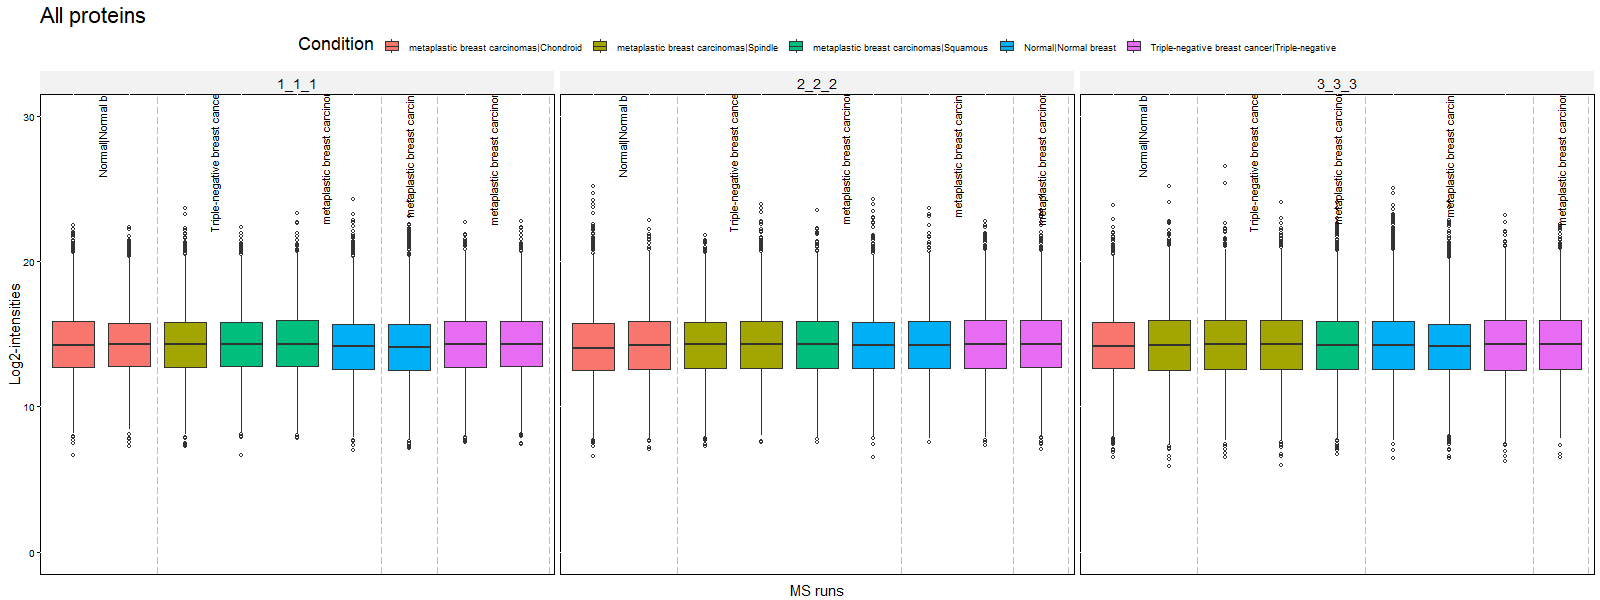

In [5]:
%%R -w 1600 -h 600

# use MSstatsTMT for protein summarization
quant_om.msstats <- proteinSummarization(input.om,
                                      method="msstats",
                                      global_norm=TRUE,
                                      reference_norm=TRUE,
                                      remove_norm_channel = TRUE,
                                      remove_empty_channel = TRUE)

print(levels(quant_om.msstats$ProteinLevelData$Condition))

protein_expression = './protein_expression.csv'

## Profile plot without norm channnels and empty channels
dataProcessPlotsTMT(data=quant_om.msstats,
                     type = 'ProfilePlot',
                     which.Protein = 'sp|Q86U42|PABP2_HUMAN',
                     width = 25, # adjust the figure width 
                     height = 12,
                     address=FALSE)
TMTProtein.Expression <- quant_om.msstats$ProteinLevelData[, c('Protein', 'Abundance', 'Condition')]
write.csv(TMTProtein.Expression, file=protein_expression, row.names=FALSE)

tmp <- levels(input.om$ProteinName)
selector <- append('allonly', tmp, 1)
## Quality control plot 
dataProcessPlotsTMT(data=quant_om.msstats, 
                     type='QCPlot',
                     which.Protein=selector,
                     width = 25, # adjust the figure width
                     height = 12,
                     address = FALSE)

In [6]:
%%R
# Check the conditions in the protein level data
levels(quant_om.msstats$ProteinLevelData$Condition)

[1] "metaplastic breast carcinomas|Chondroid"      
[2] "metaplastic breast carcinomas|Spindle"        
[3] "metaplastic breast carcinomas|Squamous"       
[4] "Normal|Normal breast"                         
[5] "Triple-negative breast cancer|Triple-negative"


In [7]:
%%R -w 1000 -h 600

Within_Subtype_Comp<-matrix(c(-1,-1,0,0,1,1,1,0,-1,0,0,0,0,0,0),nrow=3)
row.names(Within_Subtype_Comp)<-c("SQUAMOUS vs SARCOMATOID", "SPINDLE vs SARCOMATOID", "SPINDLE vs SQUAMOUS")
colnames(Within_Subtype_Comp) = c("metaplastic breast carcinomas|Chondroid","metaplastic breast carcinomas|Spindle",
                        "metaplastic breast carcinomas|Squamous","Normal|Normal breast","Triple-negative breast cancer|Triple-negative")


Within_Subtype_Comp.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix = Within_Subtype_Comp, moderated = TRUE)

Within_Subtype_Comp['SQUAMOUS vs SARCOMATOID',]

INFO  [2021-09-14 10:01:51] Model fitting for 2190 proteins.
  |======================================================================| 100%
INFO  [2021-09-14 10:03:06] Testing for 2190 proteins:
  |======================================================================| 100%
      metaplastic breast carcinomas|Chondroid 
                                           -1 
        metaplastic breast carcinomas|Spindle 
                                            0 
       metaplastic breast carcinomas|Squamous 
                                            1 
                         Normal|Normal breast 
                                            0 
Triple-negative breast cancer|Triple-negative 
                                            0 


In [8]:
%%R

Within_Subtype_Comp = Within_Subtype_Comp.pairwise$ComparisonResult
write.table(Within_Subtype_Comp,"Within_Subtype_Comp_result.csv",row.names=FALSE,col.names=TRUE,sep=",")

### MBC_three_subclasses comparing based on results given by author

                     Protein                    Label    log2FC    pvalue  \
0   sp|A0A075B6H7|KV37_HUMAN  SQUAMOUS vs SARCOMATOID  1.848396  0.157439   
1   sp|A0A075B6H7|KV37_HUMAN   SPINDLE vs SARCOMATOID  0.193783  0.897917   
2   sp|A0A075B6H7|KV37_HUMAN      SPINDLE vs SQUAMOUS -1.654613  0.288909   
3  sp|A0A075B6S5|KV127_HUMAN  SQUAMOUS vs SARCOMATOID -0.468571  0.540102   
4  sp|A0A075B6S5|KV127_HUMAN   SPINDLE vs SARCOMATOID  0.086973  0.886396   

   -Log10(p-value)    group  
0         0.802888  dimgrey  
1         0.046764  dimgrey  
2         0.539239  dimgrey  
3         0.267524  dimgrey  
4         0.052372  dimgrey  


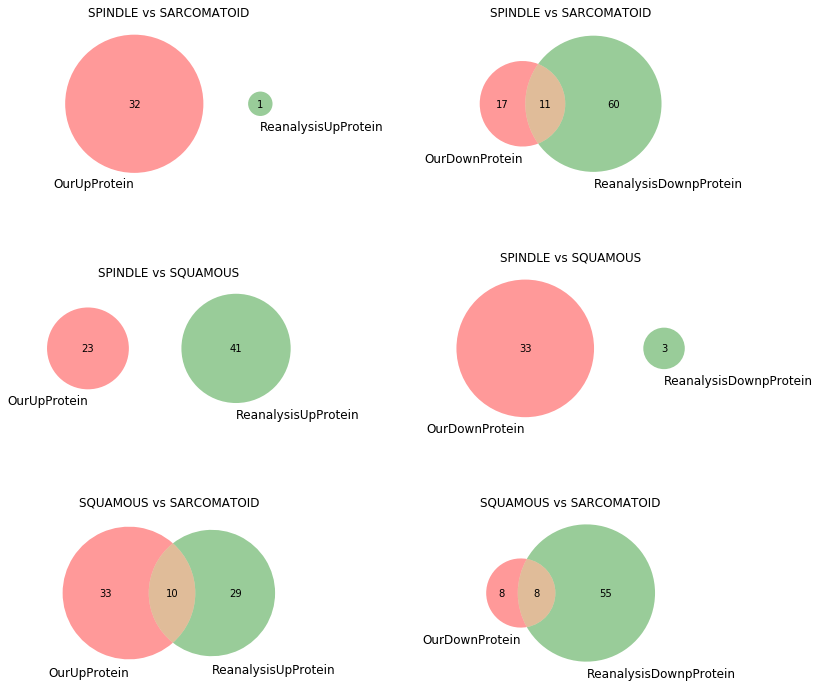

In [10]:
from matplotlib_venn import venn2


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 

result = pd.read_csv('./Within_Subtype_Comp_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > 1)&(result['pvalue'] < 0.01),'group'] = 'up' 
result.loc[(result['log2FC'] < -1)&(result['pvalue'] < 0.01),'group'] = 'down'
result.loc[result['pvalue'] >= 0.01,'group'] = 'dimgrey'
print(result.head())

# read re-analysis result
reanalysis_res = pd.read_csv("./PXD014414_MBC_three_subclasses_results.txt",
                            sep="\t")


fig = plt.figure(figsize=(12, 12))
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    if comp == "SQUAMOUS vs SARCOMATOID":
        reanalysis_downProtein = reanalysis_res[(reanalysis_res['candidate_C_Sq'] != 'no')&(reanalysis_res['direction_C_Sq'] == 'down')]['Accession'].tolist()
        reanalysis_upProtein = reanalysis_res[(reanalysis_res['candidate_C_Sq'] != 'no')&(reanalysis_res['direction_C_Sq'] == 'up')]['Accession'].tolist()
    elif comp == "SPINDLE vs SARCOMATOID":
        reanalysis_downProtein = reanalysis_res[(reanalysis_res['candidate_C_Sp'] != 'no')&(reanalysis_res['direction_C_Sp'] == 'down')]['Accession'].tolist()
        reanalysis_upProtein = reanalysis_res[(reanalysis_res['candidate_C_Sp'] != 'no')&(reanalysis_res['direction_C_Sp'] == 'up')]['Accession'].tolist()
    elif comp == "SPINDLE vs SQUAMOUS":
        reanalysis_downProtein = reanalysis_res[(reanalysis_res['candidate_Sp_Sq'] != 'no')&(reanalysis_res['direction_Sp_Sq'] == 'down')]['Accession'].tolist()
        reanalysis_upProtein = reanalysis_res[(reanalysis_res['candidate_Sp_Sq'] != 'no')&(reanalysis_res['direction_Sp_Sq'] == 'up')]['Accession'].tolist()
        
    ax = fig.add_subplot(320 + i)
    OurUpProtein = data[data['group'] == "up"]['Protein'].tolist()
    OurDownProtein = data[data['group'] == "down"]['Protein'].tolist()
    
    i += 1
    ax.set_title(comp)
    venn2(subsets=[set(OurUpProtein), set(reanalysis_upProtein)], set_labels=('OurUpProtein', 'ReanalysisUpProtein'), ax=ax)
    
    ax = fig.add_subplot(320 + i)
    ax.set_title(comp)
    venn2(subsets=[set(OurDownProtein), set(reanalysis_downProtein)], set_labels=('OurDownProtein', 'ReanalysisDownpProtein'), ax=ax)
    i += 1
    
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()

### MBC_three_subclasses comparing based on log2FC、PValue

                     Protein                    Label    log2FC    pvalue  \
0   sp|A0A075B6H7|KV37_HUMAN  SQUAMOUS vs SARCOMATOID  1.848396  0.157439   
1   sp|A0A075B6H7|KV37_HUMAN   SPINDLE vs SARCOMATOID  0.193783  0.897917   
2   sp|A0A075B6H7|KV37_HUMAN      SPINDLE vs SQUAMOUS -1.654613  0.288909   
3  sp|A0A075B6S5|KV127_HUMAN  SQUAMOUS vs SARCOMATOID -0.468571  0.540102   
4  sp|A0A075B6S5|KV127_HUMAN   SPINDLE vs SARCOMATOID  0.086973  0.886396   

   -Log10(p-value)    group  
0         0.802888  dimgrey  
1         0.046764  dimgrey  
2         0.539239  dimgrey  
3         0.267524  dimgrey  
4         0.052372  dimgrey  


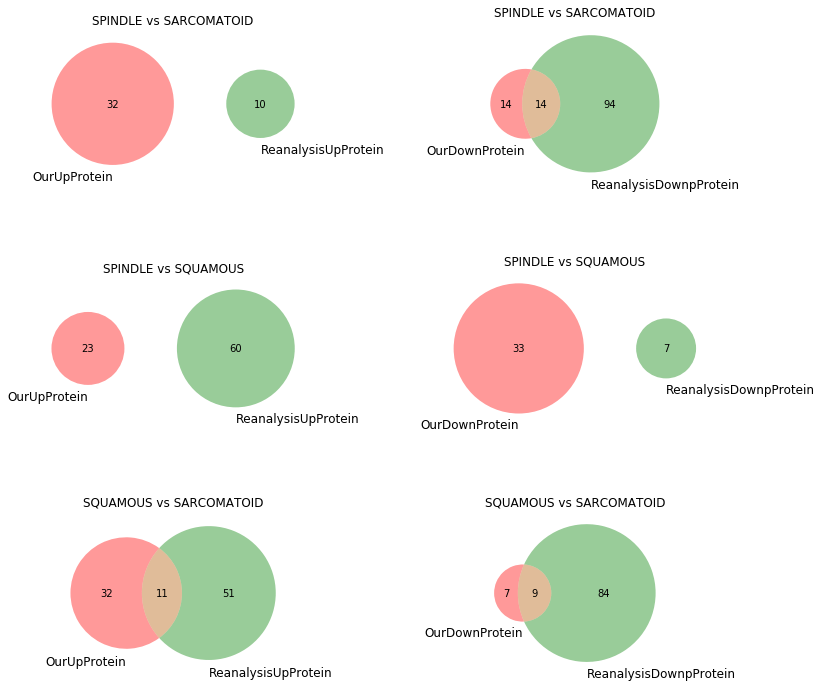

In [11]:
from matplotlib_venn import venn2


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 

result = pd.read_csv('./Within_Subtype_Comp_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > 1)&(result['pvalue'] < 0.01),'group'] = 'up' 
result.loc[(result['log2FC'] < -1)&(result['pvalue'] < 0.01),'group'] = 'down'
result.loc[result['pvalue'] >= 0.01,'group'] = 'dimgrey'
print(result.head())

# read re-analysis result
reanalysis_res = pd.read_csv("./PXD014414_MBC_three_subclasses_results.txt",
                            sep="\t")


fig = plt.figure(figsize=(12, 12))
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    if comp == "SQUAMOUS vs SARCOMATOID":
        reanalysis_downProtein = reanalysis_res[(reanalysis_res['logFC_C_Sq'] < -1)&(reanalysis_res['PValue_C_Sq'] < 0.01)]['Accession'].tolist()
        reanalysis_upProtein = reanalysis_res[(reanalysis_res['logFC_C_Sq'] > 1)&(reanalysis_res['PValue_C_Sq'] < 0.01)]['Accession'].tolist()
    elif comp == "SPINDLE vs SARCOMATOID":
        reanalysis_downProtein = reanalysis_res[(reanalysis_res['logFC_C_Sp'] < -1)&(reanalysis_res['PValue_C_Sp'] < 0.01)]['Accession'].tolist()
        reanalysis_upProtein = reanalysis_res[(reanalysis_res['logFC_C_Sp'] > 1)&(reanalysis_res['PValue_C_Sp'] < 0.01)]['Accession'].tolist()
    elif comp == "SPINDLE vs SQUAMOUS":
        reanalysis_downProtein = reanalysis_res[(reanalysis_res['logFC_Sp_Sq'] < -1)&(reanalysis_res['PValue_Sp_Sq'] < 0.01)]['Accession'].tolist()
        reanalysis_upProtein = reanalysis_res[(reanalysis_res['logFC_Sp_Sq'] > 1)&(reanalysis_res['PValue_Sp_Sq'] < 0.01)]['Accession'].tolist()
        
    ax = fig.add_subplot(320 + i)
    OurUpProtein = data[data['group'] == "up"]['Protein'].tolist()
    OurDownProtein = data[data['group'] == "down"]['Protein'].tolist()
    
    i += 1
    ax.set_title(comp)
    venn2(subsets=[set(OurUpProtein), set(reanalysis_upProtein)], set_labels=('OurUpProtein', 'ReanalysisUpProtein'), ax=ax)
    
    ax = fig.add_subplot(320 + i)
    ax.set_title(comp)
    venn2(subsets=[set(OurDownProtein), set(reanalysis_downProtein)], set_labels=('OurDownProtein', 'ReanalysisDownpProtein'), ax=ax)
    i += 1
    
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()


### (1) Triple Negative versus Normal, MBC versus Normal and MBC versus TNBC

In [12]:
%%R -w 800 -h 600

library('MSstatsTMT', warn.conflicts = F, quietly = T, verbose = F)
openms_output = './out_msstats_pre.csv'
raw.om <- read.csv(openms_output, header = TRUE, sep = ',')

raw.om$Condition[which(raw.om$Condition == "metaplastic breast carcinomas|Chondroid"|raw.om$Condition=="metaplastic breast carcinomas|Spindle"|raw.om$Condition=="metaplastic breast carcinomas|Squamous")] <- "MBC"
raw.om$Condition[which(raw.om$Condition == "not applicable|Reference Sample")] <- "Norm"

input.om <- OpenMStoMSstatsTMTFormat(raw.om)

# use MSstatsTMT for protein summarization
quant_om.msstats <- proteinSummarization(input.om,
                                      method="msstats",
                                      global_norm=TRUE,
                                      reference_norm=TRUE,
                                      remove_norm_channel = TRUE,
                                      remove_empty_channel = TRUE)

print(levels(quant_om.msstats$ProteinLevelData$Condition))

INFO  [2021-09-11 21:01:22] ** Raw data from OpenMS imported successfully.
INFO  [2021-09-11 21:01:23] ** Raw data from OpenMS cleaned successfully.
INFO  [2021-09-11 21:01:23] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements within each run will be removed.
INFO  [2021-09-11 21:01:23] ** Features with all missing measurements across channels within each run are removed.
INFO  [2021-09-11 21:01:23] ** Shared peptides are removed.
INFO  [2021-09-11 21:01:23] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-09-11 21:01:27] ** PSMs have been aggregated to peptide ions.
INFO  [2021-09-11 21:01:28] ** For peptides overlapped between fractions of 2_2_2 use the fraction with maximal average abundance.
INFO  [2021-09-11 21:01:29] ** For peptides overl

In [13]:
%%R

Main_Comp<-matrix(c(1,1,0, 0, -1, -1, -1, 0, 1),nrow=3)
row.names(Main_Comp)<-c("MBC vs TNBC", "MBC vs Normal", "TNBC vs Normal")
colnames(Main_Comp) = c("MBC","Normal|Normal breast", "Triple-negative breast cancer|Triple-negative")


Main_Comp.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix = Main_Comp, moderated = TRUE)
Main_Comp = Main_Comp.pairwise$ComparisonResult
write.table(Main_Comp,"Main_Comp_result.csv",row.names=FALSE,col.names=TRUE,sep=",")

INFO  [2021-09-11 21:02:23] Model fitting for 2231 proteins.
  |======================================================================| 100%
INFO  [2021-09-11 21:03:35] Testing for 2231 proteins:
  |======================================================================| 100%


                     Protein           Label    log2FC    pvalue  \
0   sp|A0A075B6H7|KV37_HUMAN     MBC vs TNBC -0.021967  0.983509   
1   sp|A0A075B6H7|KV37_HUMAN   MBC vs Normal -2.418570  0.040068   
2   sp|A0A075B6H7|KV37_HUMAN  TNBC vs Normal -2.396603  0.079844   
3  sp|A0A075B6S5|KV127_HUMAN     MBC vs TNBC  0.398579  0.408228   
4  sp|A0A075B6S5|KV127_HUMAN   MBC vs Normal -0.269944  0.573601   

   -Log10(p-value)    group  
0         0.007222  dimgrey  
1         1.397197  dimgrey  
2         1.097756  dimgrey  
3         0.389097  dimgrey  
4         0.241390  dimgrey  


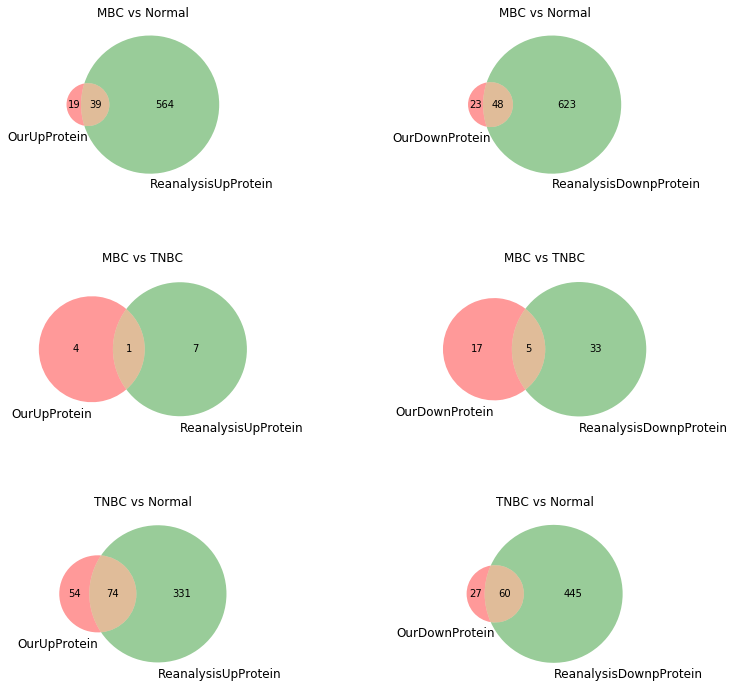

In [14]:
result = pd.read_csv('./Main_Comp_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > 1)&(result['pvalue'] < 0.01),'group'] = 'up' 
result.loc[(result['log2FC'] < -1)&(result['pvalue'] < 0.01),'group'] = 'down'
result.loc[result['pvalue'] >= 0.01,'group'] = 'dimgrey'
print(result.head())

# read re-analysis result
reanalysis_res = pd.read_csv("./PXD014414_three_tissues_results.txt",
                            sep="\t")


fig = plt.figure(figsize=(12, 12))
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    if comp == "MBC vs TNBC":
        reanalysis_downProtein = reanalysis_res[(reanalysis_res['candidate_TN_MBC'] != 'no')&(reanalysis_res['direction_TN_MBC'] == 'down')]['Accession'].tolist()
        reanalysis_upProtein = reanalysis_res[(reanalysis_res['candidate_TN_MBC'] != 'no')&(reanalysis_res['direction_TN_MBC'] == 'up')]['Accession'].tolist()
    elif comp == "MBC vs Normal":
        reanalysis_downProtein = reanalysis_res[(reanalysis_res['candidate_N_MBC'] != 'no')&(reanalysis_res['direction_N_MBC'] == 'down')]['Accession'].tolist()
        reanalysis_upProtein = reanalysis_res[(reanalysis_res['candidate_N_MBC'] != 'no')&(reanalysis_res['direction_N_MBC'] == 'up')]['Accession'].tolist()
    elif comp == "TNBC vs Normal":
        reanalysis_downProtein = reanalysis_res[(reanalysis_res['candidate_N_TN'] != 'no')&(reanalysis_res['direction_N_TN'] == 'down')]['Accession'].tolist()
        reanalysis_upProtein = reanalysis_res[(reanalysis_res['candidate_N_TN'] != 'no')&(reanalysis_res['direction_N_TN'] == 'up')]['Accession'].tolist()
        
    ax = fig.add_subplot(320 + i)
    OurUpProtein = data[data['group'] == "up"]['Protein'].tolist()
    OurDownProtein = data[data['group'] == "down"]['Protein'].tolist()
    
    i += 1
    ax.set_title(comp)
    venn2(subsets=[set(OurUpProtein), set(reanalysis_upProtein)], set_labels=('OurUpProtein', 'ReanalysisUpProtein'), ax=ax)
    
    ax = fig.add_subplot(320 + i)
    ax.set_title(comp)
    venn2(subsets=[set(OurDownProtein), set(reanalysis_downProtein)], set_labels=('OurDownProtein', 'ReanalysisDownpProtein'), ax=ax)
    i += 1
    
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()


                     Protein           Label    log2FC    pvalue  \
0   sp|A0A075B6H7|KV37_HUMAN     MBC vs TNBC -0.021967  0.983509   
1   sp|A0A075B6H7|KV37_HUMAN   MBC vs Normal -2.418570  0.040068   
2   sp|A0A075B6H7|KV37_HUMAN  TNBC vs Normal -2.396603  0.079844   
3  sp|A0A075B6S5|KV127_HUMAN     MBC vs TNBC  0.398579  0.408228   
4  sp|A0A075B6S5|KV127_HUMAN   MBC vs Normal -0.269944  0.573601   

   -Log10(p-value)    group  
0         0.007222  dimgrey  
1         1.397197  dimgrey  
2         1.097756  dimgrey  
3         0.389097  dimgrey  
4         0.241390  dimgrey  


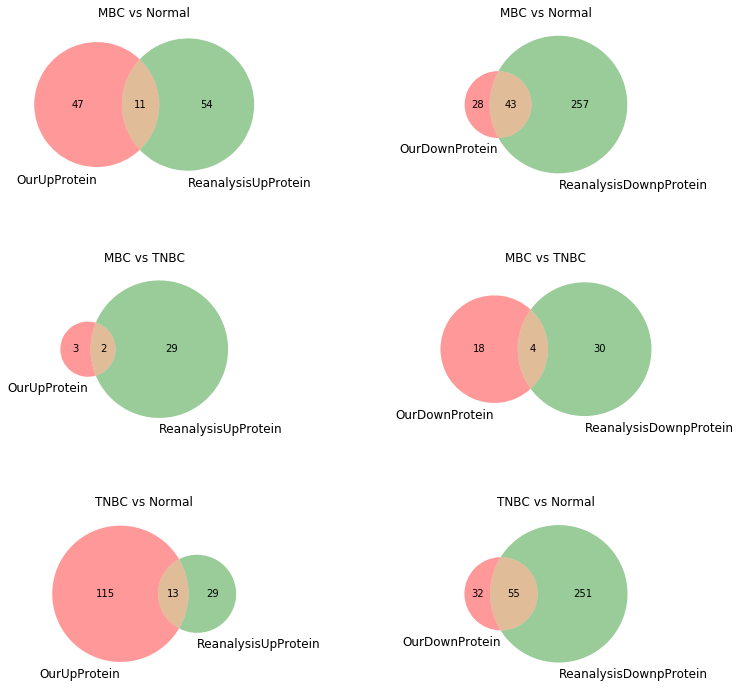

In [15]:
result = pd.read_csv('./Main_Comp_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > 1)&(result['pvalue'] < 0.01),'group'] = 'up' 
result.loc[(result['log2FC'] < -1)&(result['pvalue'] < 0.01),'group'] = 'down'
result.loc[result['pvalue'] >= 0.01,'group'] = 'dimgrey'
print(result.head())

# read re-analysis result
reanalysis_res = pd.read_csv("./PXD014414_three_tissues_results.txt",
                            sep="\t")


fig = plt.figure(figsize=(12, 12))
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    if comp == "MBC vs TNBC":
        reanalysis_downProtein = reanalysis_res[(reanalysis_res['logFC_TN_MBC'] < -1)&(reanalysis_res['PValue_TN_MBC'] < 0.01)]['Accession'].tolist()
        reanalysis_upProtein = reanalysis_res[(reanalysis_res['logFC_TN_MBC'] > 1)&(reanalysis_res['PValue_TN_MBC'] < 0.01)]['Accession'].tolist()
    elif comp == "MBC vs Normal":
        reanalysis_downProtein = reanalysis_res[(reanalysis_res['logFC_N_MBC'] < -1)&(reanalysis_res['PValue_N_MBC'] < 0.01)]['Accession'].tolist()
        reanalysis_upProtein = reanalysis_res[(reanalysis_res['logFC_N_MBC'] > 1)&(reanalysis_res['PValue_N_MBC'] < 0.01)]['Accession'].tolist()
    elif comp == "TNBC vs Normal":
        reanalysis_downProtein = reanalysis_res[(reanalysis_res['logFC_N_TN'] < -1)&(reanalysis_res['PValue_N_TN'] < 0.01)]['Accession'].tolist()
        reanalysis_upProtein = reanalysis_res[(reanalysis_res['logFC_N_TN'] > 1)&(reanalysis_res['PValue_N_TN'] < 0.01)]['Accession'].tolist()
        
    ax = fig.add_subplot(320 + i)
    OurUpProtein = data[data['group'] == "up"]['Protein'].tolist()
    OurDownProtein = data[data['group'] == "down"]['Protein'].tolist()
    
    i += 1
    ax.set_title(comp)
    venn2(subsets=[set(OurUpProtein), set(reanalysis_upProtein)], set_labels=('OurUpProtein', 'ReanalysisUpProtein'), ax=ax)
    
    ax = fig.add_subplot(320 + i)
    ax.set_title(comp)
    venn2(subsets=[set(OurDownProtein), set(reanalysis_downProtein)], set_labels=('OurDownProtein', 'ReanalysisDownpProtein'), ax=ax)
    i += 1
    
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()
